In [1]:
%matplotlib inline

intro
link to binder, website, intro, topics

- string splitting
- test with plotting
- keep mechanics

In [20]:
import numpy as np
# link to numpy tutorial TODO
import matplotlib.pyplot as plt
# link TODO
import re
# description, link to regexr TODO

In [5]:
x = "5d6"
x.split('d')

['5', '6']

In [15]:
def simple_roll(dice):
    '''docstring'''
    number, sides = dice.split('d')
    number = int(number)
    sides = int(sides)
    rolls = np.random.randint(1,sides+1, size=number)
    return rolls
    

In [16]:
simple_roll('5d6')

array([2, 5, 6, 2, 1])

Mean: 17.412


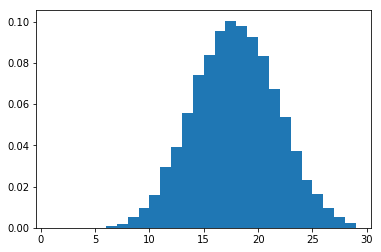

In [40]:
trials = 10000
test_rolls = [0] * trials
for i in range(trials):
    test_rolls[i] = np.sum(simple_roll('5d6'))
    
bins = np.arange(1, np.max(test_rolls))
plt.hist(test_rolls, bins=bins, density=True)
print("Mean: " + str(np.mean(test_rolls)))

TODO: explain keep notation

In [41]:
x = '4d6k3'
x.split('k')

['4d6', '3']

In [56]:
rolls = simple_roll('9d6')
rolls
x = np.partition(rolls, 4)
print(x)
x[-4:]

[2 1 2 1 3 6 6 5 6]


array([6, 6, 5, 6])

In [59]:
def keep_dice(dice):
    '''docstring'''
    base_roll, keep = dice.split('k')
    keep = int(keep)
    rolls = simple_roll(base_roll)
    #link to stack exchange for partition
    kept_rolls = np.partition(rolls, keep)[-keep:]
    return kept_rolls

In [60]:
keep_dice('4d6k3')

array([5, 6, 6])

Mean: 12.0768


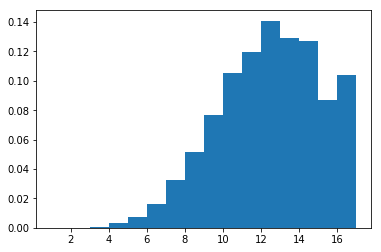

In [62]:
trials = 10000
test_rolls = [0] * trials
for i in range(trials):
    test_rolls[i] = np.sum(keep_dice('4d6k3'))
    
bins = np.arange(1, np.max(test_rolls))
plt.hist(test_rolls, bins=bins, density=True)
print("Mean: " + str(np.mean(test_rolls)))

- more complicated scenarios
- error checking

explain regular expression

In [74]:
x = re.search(r'(\d+)d(\d+)','5d6')
x.groups()

('5', '6')

In [84]:
dice_expr = r'(\d+)d(\d+)'
keep_expr = dice_expr + 'k(\d+)'
explode_expr = '(' + dice_expr + '|' + keep_expr + ')!'

In [76]:
x = re.compile(dice_expr)

In [83]:
help(x.fullmatch)

Help on built-in function fullmatch:

fullmatch(string=None, pos=0, endpos=9223372036854775807, *, pattern=None) method of _sre.SRE_Pattern instance
    Matches against all of the string



In [91]:
test_cases = {
    '5d6' : 'dice',
    '5dd6' : 'invalid',
    '90d1' : 'dice',
    '4d6k3' : 'keep',
    '4d6!' : 'explode',
    '9k3' : 'invalid',
    'lol' : 'invalid',
    '4d6k3!' : 'explode',
    '2d20k1' : 'keep'
}



In [95]:
dice_re = re.compile(dice_expr)
for dice, answer in test_cases.items():
    match = dice_re.fullmatch(dice)
    if match is not None and answer == 'dice':
        print('Good ' + dice)
    elif match is None and answer != 'dice':
        print('Good ' + dice)
    else:
        print('Bad  ' + dice)

AttributeError: '_sre.SRE_Pattern' object has no attribute 'compile'

In [93]:
re = re.compile(keep_expr)
expected_answer = 'keep'

for dice, answer in test_cases.items():
    match = re.fullmatch(dice)
    if match is not None and answer == expected_answer:
        print('Good ' + dice)
    elif match is None and answer != expected_answer:
        print('Good ' + dice)
    else:
        print('Bad  ' + dice)

Good 90d1
Good 2d20k1
Good 4d6!
Good 4d6k3!
Good 9k3
Good 4d6k3
Good 5d6
Good lol
Good 5dd6
